# Majority Voting Experiments

This is the default voting technique used in simple crowdsourcing systems.


## TODO
 * Finish debugging implementation
 * Sort out some of the code duplication.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io
import os
import random

from sklearn.externals.joblib import Parallel, delayed

%matplotlib inline

In [19]:
np.random.seed(0xF00F1E2)
random.seed(0xF00F1E2)

In [3]:
%run ../crowd/data.py
%run ../crowd/config.py
%run ../crowd/file_util.py
%run ../crowd/graph.py
%run ../crowd/topic.py

## Load data

In [4]:
id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()

In [5]:
print("{0} total useful votes, a.k.a. judgements.".format(len(judgements)))

46319 total useful votes, a.k.a. judgements.


In [6]:
DEFAULT_BUDGET = 250
COIN_FLIP = "COIN_FLIP"

# Use all cores for parallel stuff.
N_CORES = -1

In [7]:
def count_votes(votes):
    relevant_votes = 0
    non_relevant_votes = 0
    for vote in votes:
        if vote.is_relevant > 0:
            relevant_votes += 1
        elif vote.is_relevant == 0:
            non_relevant_votes += 1
        else:
            raise ValueError("Non 0/1 vote.")
    
    return relevant_votes, non_relevant_votes


def get_document_with_least_votes(vote_map):
    # TODO(andrei) Use heap, or even integrate in graph.
    # Sort the map by the values and return the key with the smallest value.
    return (sorted(vote_map.items(), key=lambda i: len(i[1])))[0][0]


def request_vote(topic_judgements, document_id):
    votes = topic_judgements[document_id]
    if len(votes) == 0:
        print("No votes found for document [{}].".format(document_id))
        return None
    
    vote = random.choice(votes)
    return vote

In [8]:
def full_mv_aggregation(document_id, topic_judgements):
    """Compute the voter consensus for the specified document.
    
    Calculation perform directly on all votes, without relying on any
    sampling.
    """
    
    if document_id not in topic_judgements:
        raise ValueError("Document ID#{0} doesn't have any votes to aggregate.".format(document_id))
        
    votes = topic_judgements[document_id]
    rel_votes, non_rel_votes = count_votes(votes)

    if rel_votes == 0 and non_rel_votes == 0:
        raise ValueError("No votes for ground truth document ID#{0}. That's a shame.".format(document_id))
        
    return rel_votes >= non_rel_votes

In [13]:
def evaluate_iteration(topic_graph, topic_judgements, ground_truth, vote_aggregation, **kw):
    """ Performs a single iteration of a learning curve simulation.
    
    Please see the 'evaluate' function for more information.
    """
    
    # The votes we aggregated so far.
    # Don't keep track of anything for which we don't have the ground truth,
    # since there's no way to evaluate that.
    votes = {n.document_id: [] for n in topic_graph.nodes
             if n.document_id in ground_truth}

    budget = kw['budget'] if 'budget' in kw else DEFAULT_BUDGET
    # How often we actually want to compute the accuracy, in terms of votes sampled.
    # We likely don't need to recompute everything after every single new vote.
    accuracy_every = kw['accuracy_every'] if 'accuracy_every' in kw else 1
    
    # TODO(andrei) Numpyfy: accuracies = np.zeros(budget // accuracy_every)
    accuracies = []
    for i in range(budget):
        # 1. Pick document (with lowest number of votes)
        document_id = get_document_with_least_votes(votes)

        # 2. Request a vote for that document (sample with replacement)
        vote = request_vote(topic_judgements, document_id)
        votes[document_id].append(vote)

        if i % accuracy_every == 0:
            # 3. Perform the aggregation
            evaluated_judgements = vote_aggregation(topic_graph, votes)

            # 4. Measure accuracy
            accuracy = measure_accuracy(evaluated_judgements, ground_truth, topic_judgements)
            accuracies.append(accuracy)
            
    return accuracies

In [14]:
def evaluate(topic_graph, topic_judgements, ground_truth, vote_aggregation, **kw):
    """ Evaluates a vote aggregation strategy for the specified topic.
    
    Args:
        topic_graph: The document graph of the topic on which we want to
            perform the evaluation.
        topic_judgements: The votes from which we sampled, as a map from
            document ID to a list of 'JudgementRecord's.
        ground_truth: A map of document IDs ground truth 'ExpertJudgement's.
        vote_aggregation: Function used to aggregate a document's votes and
            produce a final judgement.
            
    Returns:
        TODO(andrei) TBD    
        
    Notes:
        TODO(andrei) Consider using loggers to control output verbosity.
        
    """
    iterations = kw['iterations'] if 'iterations' in kw else 10
    progress_every = kw['progress_every'] if 'progress_every' in kw else 50
    # verbose = kw['verbose'] if 'verbose' in kw else False
        
#     print("Performing evaluation of topic [{}].".format(topic_graph.topic))
#     print("Aggregation function: [{}]".format(vote_aggregation))
    
    all_accuracies = Parallel(n_jobs=N_CORES)(
        delayed(evaluate_iteration)(topic_graph, topic_judgements, ground_truth, vote_aggregation, **kw) 
        for idx in range(iterations))

#    for iteration in range(iterations):
#         if progress_every != -1 and (iteration % progress_every == 0):
#                 print("Iteration {}/{}.".format(iteration + 1, iterations))

#         accuracies = []
#         all_accuracies.append(accuracies)
        
        

    return all_accuracies

In [54]:
def aggregate_MV(topic_graph, votes):
    """The default way of aggregating crowdsourcing votes.
    
    Args:
        topic_graph: The current topic's document graph. Not used.
        votes: A map from document ID to a list of sampled 'JudgementRecord's.
        
    Returns:
        A map which contains a boolean relevance for every document.
    """
       
    return {document_id: majority(document_votes)
            for (document_id, document_votes) in votes.items()}
            
    
def majority(votes, tie_handling=COIN_FLIP):
    """Computes the majority of a list of 'JudgementRecord's.
    
    Args:
        votes: A list of 'JudgementRecord' objects.
        tie_handling: An enum specifying how ties are to be treated.
    
    Returns:
        A boolean indicating whether the consensus is "relevant".
        Ties are broken as specified by the 'tie_handling' parameter.
        
    """
    # Note: mind the Nones!
    relevant = len([vote for vote in votes if vote.is_relevant == True])
    non_relevant = len([vote for vote in votes if vote.is_relevant == False])
    
    if relevant > non_relevant:
         return True
    elif relevant < non_relevant:
         return False
    elif tie_handling == COIN_FLIP:
        return random.choice([True, False])
    else:
        raise ValueError("Unknown tie handling technique: [{}]."
                         .format(tie_handling))


def measure_accuracy(evaluated_judgements, ground_truth, topic_judgements):
    # TODO(andrei) Vectorize this computation as much as possible.
    match = 0
    fail = 0
    
    for doc_id in ground_truth:
        # TODO(andrei) Don't make it this far with shitty data. Filter useless GTs earlier on!
        # Unestabilshed relevance in ground truth.
        if ground_truth[doc_id].label < 0:
            continue
            
        gt_label = (ground_truth[doc_id].label > 0)        
        evaluated_label = evaluated_judgements[doc_id]
        if gt_label == evaluated_label:
            match += 1
        else:
            fail += 1
            
    return match / (match + fail)


def build_learning_curve(topic_id, **kw):
    topic = id_topic_info[topic_id]
    graph = build_document_graph(topic, FULLTEXT_FOLDER)
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == topic_id}
    

    # i.e. up to target_votes votes per doc, on average.
    # TODO(andrei) Make this cleaner and more seamless.
    max_votes = kw['max_votes'] if 'max_votes' in kw else 3
    bud = len(topic_judgements) * max_votes
    acc = evaluate(
        graph,
        topic_judgements,
        topic_ground_truth,
        aggregate_MV,
        budget=bud,
        **kw)

    acc = np.array(acc)
    acc_avg = np.mean(acc, axis=0)        
    return acc_avg

        
def plot_mv_learning_curve(topic_id, **kw):
    acc_avg = build_learning_curve(topic_id, **kw)
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    plt.plot(np.arange(len(acc_avg)) / len(topic_judgements), acc_avg)
    plt.xlabel("Mean votes per document")
    plt.ylabel("Accuracy")
    return acc_avg

115
0.792222222222


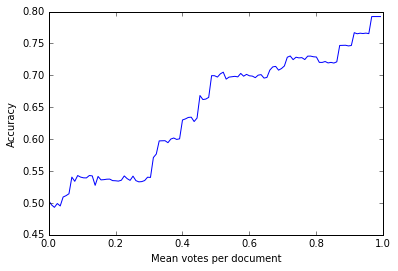

In [58]:
# plot_mv_learning_curve('20910')
#plot_mv_learning_curve('20996', iterations=50)
acc_avg = plot_mv_learning_curve('20686', iterations=1500, max_votes=1)
print(len(acc_avg))
print(acc_avg[-1])

In [59]:
after_one_vote = {}
topic_count = len(id_topic_info)

for i, (topic_id, topic) in enumerate(id_topic_info.items()):
    print("Topic %d/%d" % (i + 1, topic_count))
    data = build_learning_curve(
        topic_id,
        iterations=1000,
        max_votes=1,
        progress_every=-1)

    after_one_vote[topic_id] = data[-1]    

Topic 1/30
Topic 2/30
Topic 3/30
Topic 4/30
Topic 5/30
Topic 6/30
Topic 7/30
Topic 8/30
Topic 9/30
Topic 10/30
Topic 11/30
Topic 12/30
Topic 13/30
Topic 14/30
Topic 15/30
Topic 16/30
Topic 17/30
Topic 18/30
Topic 19/30
Topic 20/30
Topic 21/30
Topic 22/30
Topic 23/30
Topic 24/30
Topic 25/30
Topic 26/30
Topic 27/30
Topic 28/30
Topic 29/30
Topic 30/30


In [60]:
paper_standard_mv = {
    '20424': 0.594,
    '20488': 0.667,
    '20542': 0.676,
    '20584': 0.689,
    '20636': 0.716,
    '20642': 0.693,
    '20686': 0.693,
    '20690': 0.703,
    '20694': 0.726,
    '20696': 0.562,
    '20704': 0.670,
    '20714': 0.808,
    '20764': 0.676,
    '20766': 0.796,
    '20778': 0.652,
    '20780': 0.641,
    '20812': 0.688,
    '20814': 0.792,
    '20832': 0.630,
    '20910': 0.661,
    '20916': 0.650,
    '20932': 0.576,
    '20956': 0.616,
    '20958': 0.610,
    '20962': 0.552,
    '20972': 0.668,
    '20976': 0.632,
    '20996': 0.542
    # TODO(andrei) Add the rest.
}

def rmse_own_results(own_result_map):
    rmse = 0.0
    for topic_id, mv_score in paper_standard_mv.items():
        rmse += abs(own_result_map[topic_id] - mv_score) ** 2
    
    rmse /= len(paper_standard_mv)
    return rmse

In [61]:
print(rmse_own_results(after_one_vote))

0.0098879072574


* rmse = 0.44473 when comparing all votes to 0.0
* rmse = 0.03119 when comparing all votes to 0.5
* rmse = 0.01002 when running 500 iterations (30 Apr)
* rmse = 0.00989 when running 1000 iterations (30 Apr)